# **Deep Learning applied on Nairobi slum**

## Import libraries

In [1]:
import tensorflow as tf
import os, sys
import numpy as np
import h5py

In [2]:
#from stackage import stackage

In [3]:
def import_hf5(data_path, data_name, get_name):
    hf = h5py.File(os.path.join(data_path, data_name), mode="r")
    data = hf.get(get_name)
    stack = np.array(data)
    hf.close()
    return stack

In [4]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

## Importing data RGB

In [5]:
data_path = 'Images/small_raster/tr_RGBNIR_patch/'
data_name = "RGBNIR.hdf5"
path_raster = import_hf5(data_path,data_name,'raster')

patch_id_train = import_hf5(data_path,data_name,'id_train')
patch_id_test = import_hf5(data_path,data_name,'id_test')

patch_lulc_train = import_hf5(data_path,data_name,"lulc_train")
patch_lulc_test = import_hf5(data_path,data_name,"lulc_test")

patch_id = import_hf5(data_path,data_name,"patch_id")

In [6]:
print(patch_id_train.shape)

(2074, 1)


### Separate train patchs to test patchs

In [7]:
train_path = []
test_path = []

patch_id_train_re = patch_id_train.reshape(1,patch_id_train.size)
patch_id_train_list = patch_id_train_re.tolist()[0]
patch_id_test_re = patch_id_test.reshape(1,patch_id_test.size)
patch_id_test_list = patch_id_test_re.tolist()[0]

for path in path_raster : #récupération des id des images
    image = path.split(b'/')[-1]
    image_id = int(image.split(b'_')[-2])
    if image_id in patch_id_train_list :
        index = patch_id_train_list.index(image_id)
        train_path.insert(index,path)
    elif image_id in patch_id_test_list :
        index = patch_id_test_list.index(image_id)
        test_path.insert(index,path)

In [8]:
from osgeo import gdal
import numpy as np

#code inspired from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def stackage(list_raster):
    stack = []
    for patch in list_raster :
        pat = gdal.Open(patch.decode('ascii'))
        data_rast = pat.ReadAsArray().astype(np.float32)
        data_rast = np.transpose(data_rast,(1,2,0))
        stack.append(data_rast)

    stack= np.array(stack)
    
    return stack


In [9]:
stack = stackage(train_path)
stack_train = normalise_01(stack)
stack = stackage(test_path)
stack_test = normalise_01(stack)

[1472. 1128.  962. 1698.]
[68449]
68449
(2074, 10, 10, 4)
(2074, 1)


## Importing data SAR

In [ ]:
data_path = 'Images/small_raster/tr_SAR_patch/'
data_name = "RGBNIR.hdf5"
path_raster = import_hf5(data_path,data_name,'raster')

sar_id_train = import_hf5(data_path,data_name,'id_train')
sar_id_test = import_hf5(data_path,data_name,'id_test')

sar_lulc_train = import_hf5(data_path,data_name,"lulc_train")
sar_lulc_test = import_hf5(data_path,data_name,"lulc_test")

sar_id = import_hf5(data_path,data_name,"patch_id")

# **Starting deep learning**


## **Model based on the tutorial**

### Creating model

In [67]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(10, 10, 4)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
  tf.keras.layers.Dropout(0.4, name = 'fc1_drop', seed=3)
])


In [68]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 8, 8, 16)          592       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 32)          4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [69]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [70]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') > 0.798:
      print("\n Enough accuracy")
      self.model.stop_training = True
        
callbacks = myCallback()

### Training model

In [71]:
history = model.fit(stack_train, patch_lulc_train, epochs=20, batch_size=10, callbacks=[callbacks])

Epoch 1/20
208/208 [==============================] - 3s 12ms/step - loss: 5.1657 - accuracy: 0.5728
Epoch 2/20
208/208 [==============================] - 2s 12ms/step - loss: 5.1685 - accuracy: 0.5661
Epoch 3/20
208/208 [==============================] - 2s 10ms/step - loss: 5.3418 - accuracy: 0.5554
Epoch 4/20
208/208 [==============================] - 2s 11ms/step - loss: 5.4504 - accuracy: 0.5482
Epoch 5/20
208/208 [==============================] - 2s 11ms/step - loss: 5.1561 - accuracy: 0.5646
Epoch 6/20
208/208 [==============================] - 2s 11ms/step - loss: 5.3879 - accuracy: 0.5550
Epoch 7/20
208/208 [==============================] - 2s 11ms/step - loss: 5.2775 - accuracy: 0.5598
Epoch 8/20
208/208 [==============================] - 2s 12ms/step - loss: 5.0330 - accuracy: 0.5767
Epoch 9/20
208/208 [==============================] - 3s 12ms/step - loss: 5.0780 - accuracy: 0.5714
Epoch 10/20
208/208 [==============================] - 2s 12ms/step - loss: 5.4926 - accura

**L'accuracy** : 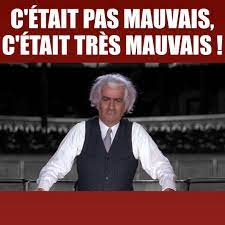

### Evaluating model

In [72]:
model.evaluate(stack_test,patch_lulc_test)

17/17 [==============================] - 0s 3ms/step - loss: 0.5222 - accuracy: 0.8247


[0.5221656560897827, 0.8246628046035767]

In [73]:
data_path = 'Images/small_raster/g_RGBNIR_patch/'
data_name = "grid.hdf5"
path_grid_raster = import_hf5(data_path,data_name,'raster')
patch_id_raster = import_hf5(data_path,data_name,'patch_id')

In [74]:
stack = stackage(path_grid_raster)

In [75]:
stack_grid = normalise_01(stack)

In [76]:
predict = model.predict(stack_grid)

382/382 [==============================] - 2s 4ms/step


In [77]:
print(predict)

[[0.52432287]
 [0.52198595]
 [0.53152114]
 ...
 [0.5065742 ]
 [0.5089235 ]
 [0.50644106]]


In [78]:
#patch_id_raster = np.array(patch_id_raster.reshape(patch_id_raster.size,1))

In [79]:
#patch_id_raster = patch_id_raster.tolist()

In [80]:
print(min(predict))

[0.48939207]


In [81]:
import csv

predict = predict.reshape(1,predict.size).tolist()[0]

header = ['prob_slum','id']
cont = []
cont.append(header)
for x,y in zip(predict,patch_id_raster):
    current_row = [x,y]
    cont.append(current_row)
    
cont

with open('prob_slum.csv','w') as file :
    write = csv.writer(file)
    write.writerows(cont)

## **VGG**

### Import libraries

In [58]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import cv2
import shutil
import time
import tempfile
import h5py



from IPython.display import clear_output



import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from keras.utils import np_utils
from keras.constraints import max_norm
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [59]:
print(tf.__version__)

2.9.1


In [60]:
! nvidia-smi

Mon Jul 18 13:27:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:05:00.0  On |                  N/A |
|  0%   47C    P8    10W / 200W |   7889MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [61]:
import random as python_random
SEED = 101
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()


In [62]:
# Add local module to the path
src = os.path.abspath('SRC/')
if src not in sys.path:
    sys.path.append(src)


In [63]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train, plot_loss_multirun
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file
# Import LRFinder function
from LRFinder import LRFinder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


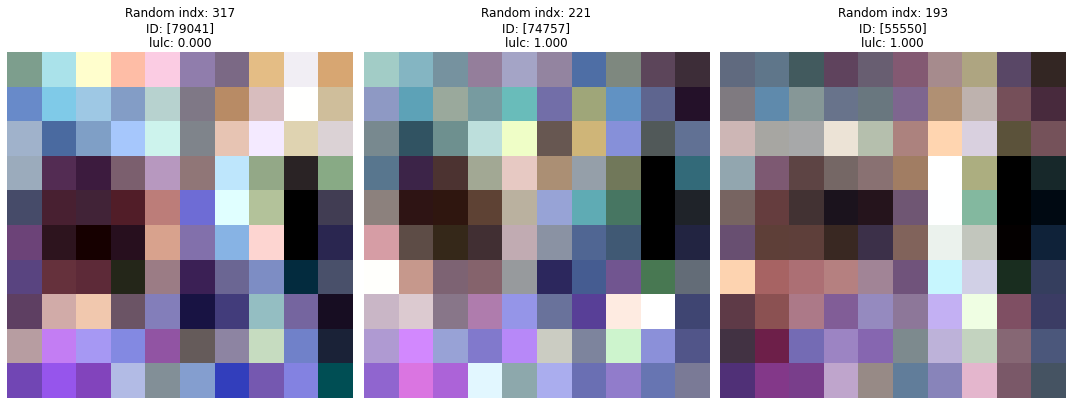

In [91]:
# Random selection
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(15, 15))
for i in range(3):
    rd_img = np.random.randint(1,500)
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(Norma_Xpercentile(stack_test[rd_img,:,:,:]))
    plt.axis("off")
    plt.title("Random indx: %s\nID: %s\nlulc: %0.3f" %(rd_img,patch_id_train[rd_img],patch_lulc_train[rd_img]))
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 

In [89]:
print(stack_train[352,0,0,:])
print(stack_train[12,0,0,:])
print(stack_train[338,0,0,:])

[0.212701   0.20289855 0.24676089 0.14758027]
[0.3368614  0.3718141  0.39634866 0.25251558]
[0.24486057 0.18890555 0.17314488 0.27359846]


# **Y-Model : RGBNIR AND SAR**

## Import Libraries

In [82]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [83]:
left_input_shape = (10,10,4)
right_input_shape = (10,10,3)
batch_sizer = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

In [ ]:
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters

# 1 layer of Conv2D-Dropout-MaxPooling2D

for i in range(1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2


In [ ]:
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters

# 1 layer of Conv2D-Dropout-MaxPooling2D

for i in range(1):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2


In [ ]:
# merge left and right branches outputs
y = concatenate([x, y])

In [ ]:
# feature maps to vector before connecting to Dense 
num_labels = [0,1]
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)


In [ ]:
model = Model([left_inputs, right_inputs], outputs)

In [ ]:
model.summary()


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit([stack_train, stack_sar_train],
          patch_lulc_train, 
          validation_data=([stack_test, stack_sar_test], patch_lulc_test),
          epochs=20,
          batch_size=batch_size)

# **Garbage**

In [60]:
import csv

#predict = predict.reshape(1,predict.size).tolist()[0]

header = ['prob_slum','id']
cont = []
cont.append(header)
for x,y in zip(predict,patch_id_raster):
    current_row = [x,y]
    cont.append(current_row)
    
cont

with open('prob_slum.csv','w') as file :
    write = csv.writer(file)
    write.writerows(cont)

In [93]:
a = ['a','b','c']
b = [1,2,3]
content = []
header = ["col1", "col2"]
content.append(header)
for x,y in zip(a,b):
    current_row = [x,y]
    content.append(current_row)
    
content

import csv
with open('example.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(content)

In [86]:
tuple_

In [ ]:
import os, signal

os.kill(os.getpid() , signal.SIGKILL)

In [79]:
a = np.array([[1, 2, 3], [3, 4, 5]])

In [81]:
print(a)
print(a.shape)

[[1 2 3]
 [3 4 5]]
(2, 3)


In [84]:
print(a.transpose(0,1))

[[1 2 3]
 [3 4 5]]
